In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from itertools import combinations

from tqdm import tqdm
import numpy as np

In [2]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [3]:
div_time = {'mr': 13.10, 'cs': 24.60,'hr': 28.82, 'cd': 55.4, 'csp': 61.8,'cspcd': 76.0,'mrr': 79.0,  'hrmrr': 87.2, 'hrmrrcspcd': 94.0, 'hrmrrcspcdc': 325.9, 'hrmrrcspcdcz': 429.0}

In [4]:
colors = {'rodents': "#64b5f6",             #mr
          'primates': "#0d47a1",            #hr
          'glires': "#1976d2",              #mrr
          'eurarchontoglires': "#2196f3",   #hrmrr

          'cattle': "#ffe566",              #cs
          'carnivores': "#ffb700",          #cd
          'ungulates': "#ffdd32",           #csp
          'laurasians': "#ffd400",          #cspcd

          'mammals': "#7fb446",             #hrmrrcspcd
          'tetrapods': "#a98467",           #hrmrrcspcdc
          'vertebrates': "#515151"          #hrmrrcspcdcz
          }

colors_sorted = {i:colors[i] for i in colors.keys() }

In [5]:
def get_code_conversion(code):
    alignment_code_to_species = {'hr':          'human;rhesus',
                                 'mr':          'mouse;rat',
                                 'cd':          'cat;dog',
                                 'cs':          'cow;sheep',
                                 'csp':         'pig;cow;sheep',
                                 'mrr':         'mouse;rabbit;rat',
                                 'cspcd':       'pig;cow;sheep;dog;cat',
                                 'hrmrr':       'human;mouse;rhesus;rabbit;rat',
                                 'hrmrrcspcd':  'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat',
                                 'hrmrrcspcdc': 'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken',
                                 'hrmrrcspcdcz':'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken;zfish'}
    return alignment_code_to_species.get(code)

In [6]:
def get_sb_len(species,aln,path="/Users/fabianpa/Desktop/new_sequences/synteny_3/synteny_bed"):
    sb_dfs = []
    for common_name in species:
        fname = os.path.join(path,common_name+"_"+aln+".bed")
        sb_df = pd.read_table(fname, names=("chr", "start", "stop", "aln", "strand"),header=None)
        sb_df["species"] = common_name
        sb_df["sb_length"]  = sb_df["stop"]- sb_df["start"]
        sb_dfs.append(sb_df)
    return pd.concat(sb_dfs, axis=0)

def get_tad_in_sb(species, aln,sb_coord,sb_specific_aln=None,shuffle=False,coord_path="/Users/fabianpa/Desktop/new_sequences/sb_in_tad_3/"):
    count_df = []
    coord_df = []
    for common_name in species:
        coord_fname = os.path.join(coord_path, f"{common_name.lower()}_{aln}.tad.sb")
        specie_aln_name = common_name.lower()+"_"+aln
        try:
            sb_tad_coord = pd.read_csv(coord_fname,sep="\t",usecols=[5,6,7,3,4], names=("aln", "strand", "chr", "start", "stop"),header=None)[["chr", "start", "stop", "aln", "strand"]]
            sb_tad_coord["species"] = common_name
            sb_tad_coord["tad_size"] = sb_tad_coord["stop"] - sb_tad_coord["start"]
            if sb_specific_aln :  coord_df.append(sb_tad_coord[sb_tad_coord.aln.isin(sb_specific_aln[specie_aln_name])])
            else: coord_df.append(sb_tad_coord)
            count_list = []
            for i in sb_coord.aln.unique():
                count = len(sb_tad_coord[(sb_tad_coord.aln==i)])
                # if i == "Alignment218": print(count,common_name,i)
                count_list.append([i,count,common_name])
                
            if sb_specific_aln :
                df = pd.DataFrame(count_list, columns=['aln', 'count',"species"])
                if shuffle:df["count"] = df["count"].sample(frac=1).values
                count_df.append(df[df["aln"].isin(sb_specific_aln[specie_aln_name])])
            else: count_df.append(pd.DataFrame(count_list, columns=['aln', 'count',"species"]))

        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found: {e.filename}")
    return count_df, coord_df

In [7]:
def calculate_average_relative_difference(tad_sb_df, species,shuffle=False):
    """
    Calculate the average relative difference for TAD-SB counts across alignments.

    Parameters
    ----------
    tad_sb_df : pandas.DataFrame containing TAD-SB count information.
    species : list of species codes.

    Returns
    -------
    float: The average relative difference across alignments.

    Notes
    -----

    relative_difference = |x - y| / mean(x,y)
    average_relative_difference = (sum_of_relative_differences) / N -----> N is the number of SB in the SBF
    average_relative_difference (more than two species) = (average_relative_difference1 + average_relative_difference2 + ... + average_relative_differenceN) / S --> Number of possible combinations
    """

    rad = []
    for s in species:
        if shuffle: 
            s1_counts = tad_sb_df.loc[(tad_sb_df.species == s[0]), "count"].sample(frac=1).values
        else : 
            s1_counts = tad_sb_df.loc[(tad_sb_df.species == s[0]), "count"].values
        s2_counts = tad_sb_df.loc[(tad_sb_df.species == s[1]), "count"].values
        abs_diff = [0 if x==y else abs(x-y)/(sum([x,y])/2) for x,y in zip(s1_counts,s2_counts)]
        rad.extend(abs_diff)   
    mean_ratio = np.mean(rad)
    return mean_ratio

def get_avg_min_max(tad_sb_df, species,shuffle=False):
    """
    Calculate the average ratio of minimum conserved TADs to maximum possible conserved TADs.

    The function calculates the average ratio of the minimum number of conserved TADs to the maximum possible number
    of conserved TADs across alignments.

    Parameters
    ----------
    tad_sb_df: pandas.DataFrame containing TAD-SB count information.
    species: list of species codes.

    Returns
    -------
    pandas.DataFrame containing the average ratio for each alignment.

    Raises
    ------
    KeyError
        If the required columns are not found in the DataFrame.

    Notes
    -----
    The function first calculates the maximum possible number of conserved TADs for each species combination.
    Then, for each alignment, it calculates the minimum number of conserved TADs and computes the ratio
    of minimum conserved TADs to maximum possible conserved TADs. The average ratio across alignments is returned.
    """

    ratio_list = []
    try:
        for s in species:
            if shuffle: count_s0 = tad_sb_df.loc[(tad_sb_df.species == s[0]), "count"].sample(frac=1).values
            else: count_s0 = list(tad_sb_df["count"][tad_sb_df.species==s[0]].values)
            count_s1 = list(tad_sb_df["count"][tad_sb_df.species==s[1]].values)
            ratios = [min(x,y)/max(x,y) if not 0 in (x,y) else 0 for x,y in zip(count_s0,count_s1)]

            ratio_list.extend(ratios)
    except KeyError as e:
        raise KeyError("Required columns not found in DataFrame: {}".format(e))
    mean_ratio = np.mean(ratio_list)
    return mean_ratio

In [8]:
count_comparison = []
rdm_count_comparison = []
count_comparison_comb = []
rdm_count_comparison_comb = []

outer_pbar = tqdm(div_time.keys(),position=0, leave=True,colour='blue')
# outer_pbar = tqdm(['hr'],position=0, leave=True,colour='blue')

for aln in outer_pbar:
    outer_pbar.set_description(f'Processing Alignments - {aln}')
    species = get_code_conversion(aln).split(';')
    sb_coord = get_sb_len(species,aln)
    tad_sb_list,tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
    tad_sb_df = pd.concat(tad_sb_list, axis=0)
    # tad_sb_df.aln = tad_sb_df.aln.apply(lambda x: "sb_{}".format(int(x.split("Alignment")[1])))
    tad_sb_df.sort_values(by='aln', inplace=True)
    
    # print(tad_sb_df.loc[tad_sb_df.aln.isin(['Alignment12','Alignment84'])])
    comb = list(combinations(species, 2))
    ard = calculate_average_relative_difference(tad_sb_df, comb)

    mmr = get_avg_min_max(tad_sb_df,comb)
    count_comparison.append([aln, div_time[aln], ard , mmr])
    
    random_ard = []
    random_mmr = []
    
    for _ in range(100):
        rdm_ard = calculate_average_relative_difference(tad_sb_df, comb,shuffle=True)
        rdm_mmr = get_avg_min_max(tad_sb_df, comb,shuffle=True)
        random_ard.append(rdm_ard)
        random_mmr.append(rdm_mmr)

    rdm_count_comparison.append([aln, div_time[aln], np.mean(random_ard) , np.mean(random_mmr),random_ard,random_mmr])

species_mapping = {'hr':'primates','mr':'rodents','cs':'cattle','cd':'carnivores','csp':'ungulates','cspcd':'laurasians','mrr':'glires','hrmrr':'eurarchontoglires','hrmrrcspcd':'mammals','hrmrrcspcdc':'tetrapods',"hrmrrcspcdcz":"vertebrates"}

count_comparison_df = pd.DataFrame(count_comparison, columns=['alignment', 'mya', 'ard', 'mmr'])
rdm_count_comparison_df = pd.DataFrame(rdm_count_comparison, columns=['alignment', 'mya', 'ard', 'mmr',"ard_distr","mmr_distr"])
rdm_count_comparison_df["alignment"] = rdm_count_comparison_df["alignment"].replace(species_mapping)
count_comparison_df["alignment"] = count_comparison_df["alignment"].replace(species_mapping)
count_comparison_df["color"] = count_comparison_df["alignment"].map(colors)
count_comparison_df

Processing Alignments - hrmrrcspcdcz: 100%|██████████| 11/11 [00:28<00:00,  2.57s/it]


,alignment,mya,ard,mmr,color
0,rodents,13.10,0.279759,0.783132,#64b5f6
1,cattle,24.60,0.425948,0.679663,#ffe566
2,primates,28.82,0.321881,0.742316,#0d47a1
3,carnivores,55.40,0.443996,0.699604,#ffb700
4,ungulates,61.80,0.356349,0.738964,#ffdd32
5,laurasians,76.00,0.334901,0.761117,#ffd400
6,glires,79.00,0.325360,0.765405,#1976d2
7,eurarchontoglires,87.20,0.302198,0.777016,#2196f3
8,mammals,94.00,0.296067,0.782989,#7fb446
9,tetrapods,325.90,0.324166,0.771253,#a98467


In [10]:
merged_df = count_comparison_df.merge(rdm_count_comparison_df, on=['alignment','mya'],suffixes=('_actual','_random'))
merged_df['ard_ratio'] = merged_df['ard_actual'] / merged_df['ard_random']
merged_df['mmr_ratio'] = merged_df['mmr_actual'] / merged_df['mmr_random']
merged_df

,alignment,mya,ard_actual,mmr_actual,color,ard_random,mmr_random,ard_distr,mmr_distr,ard_ratio,mmr_ratio
0,rodents,13.10,0.279759,0.783132,#64b5f6,1.267687,0.284537,"[1.2089838717737378, 1.3212522932486155, 1.262...","[0.2729252129663689, 0.268555850158531, 0.3028...",0.220685,2.752304
1,cattle,24.60,0.425948,0.679663,#ffe566,1.280161,0.302072,"[1.3511986361121222, 1.2631778470606374, 1.220...","[0.3658483806767887, 0.32802970504371287, 0.30...",0.332730,2.250003
2,primates,28.82,0.321881,0.742316,#0d47a1,1.347026,0.261078,"[1.289218630236876, 1.2735519625283311, 1.4414...","[0.27410110826499035, 0.27967148134062997, 0.2...",0.238957,2.843269
3,carnivores,55.40,0.443996,0.699604,#ffb700,1.297643,0.276505,"[1.2581313013012587, 1.2855090927789556, 1.328...","[0.29795720916104634, 0.2768734965858638, 0.29...",0.342156,2.530170
4,ungulates,61.80,0.356349,0.738964,#ffdd32,1.193245,0.312966,"[1.159844649127357, 1.181242907764548, 1.22193...","[0.3065672793416781, 0.3190649705835107, 0.302...",0.298638,2.361162
5,laurasians,76.00,0.334901,0.761117,#ffd400,1.040342,0.382739,"[1.0271771502903837, 1.0328514104964945, 1.048...","[0.3758747145388911, 0.380758274271538, 0.3831...",0.321914,1.988604
6,glires,79.00,0.325360,0.765405,#1976d2,1.024379,0.384020,"[1.0237090380992118, 1.0385193690487762, 1.033...","[0.3836631770694588, 0.36992182640311694, 0.37...",0.317617,1.993136
7,eurarchontoglires,87.20,0.302198,0.777016,#2196f3,0.976049,0.405142,"[0.9726492961932812, 0.9721225698924627, 0.964...","[0.3985469913140506, 0.39290560514369377, 0.40...",0.309613,1.917887
8,mammals,94.00,0.296067,0.782989,#7fb446,0.816605,0.482332,"[0.8147249322731538, 0.8165355675341177, 0.819...","[0.480597422171419, 0.4826795181653962, 0.4826...",0.362558,1.623340
9,tetrapods,325.90,0.324166,0.771253,#a98467,0.649491,0.574418,"[0.6489727477425311, 0.6446950609017905, 0.647...","[0.5718239328677043, 0.5752008425513566, 0.574...",0.499108,1.342669


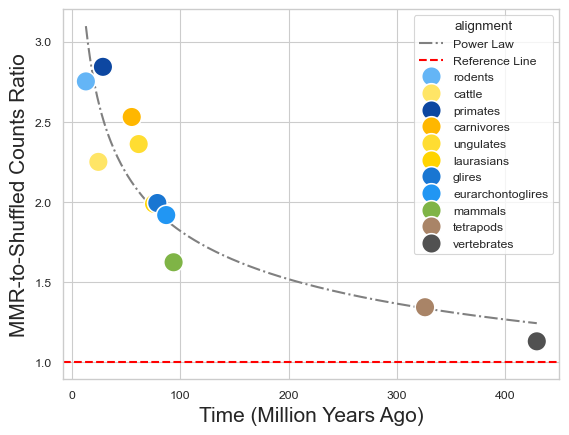

In [11]:
plt.figure(figsize=(6.4, 4.8))

X = merged_df["mya"]
Y = merged_df["mmr_ratio"]
 
log_x = np.log(X)
log_y = np.log(Y)

coefficients = np.polyfit(log_x, log_y, 1)
b = coefficients[0] 
a = np.exp(coefficients[1]) 

x_values = np.linspace(X.min(), X.max(), 400)
y_values = a * x_values ** b

plt.plot(x_values, y_values,  color='grey', linestyle="-.",label='Power Law',linewidth=1.5,zorder=1)
plt.axhline(y=1, color='r',linestyle="--",label='Reference Line',linewidth=1.5)
sns.scatterplot(x=merged_df["mya"], y=merged_df["mmr_ratio"], hue=merged_df.alignment,palette=list(merged_df["color"]),s=200)

# Add labels and legend
plt.xlabel("Time (Million Years Ago)",fontsize=15)
plt.ylabel("MMR-to-Shuffled Counts Ratio",fontsize=15)
handles, labels = plt.gca().get_legend_handles_labels()
# labels = [f"{label}:{alignment_code_to_species_legend[label]}" if label in alignment_code_to_species_legend.keys() else label for label in labels]
plt.tick_params(axis='both', which='major')

# plt.savefig("../images/figure 3/count_mmr_fitted.1.png", bbox_inches='tight',dpi=600)
plt.savefig("../images/figure 3/count_mmr_fitted.2.svg", bbox_inches='tight')
plt.show()

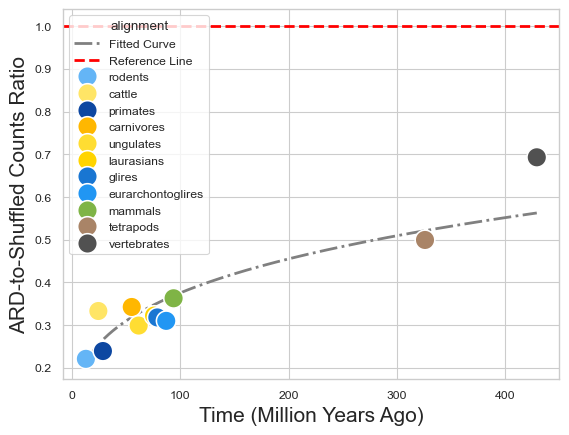

In [14]:
plt.figure(figsize=(6.4, 4.8))

X = merged_df["mya"]
Y = merged_df["ard_ratio"]
 
log_x = np.log(X)
log_y = np.log(Y)

coefficients = np.polyfit(log_x, log_y, 1)
b = coefficients[0] 
a = np.exp(coefficients[1]) 

x_values = np.linspace(X.min(), X.max(), 400)
y_values = a * x_values ** b

plt.plot(x_values, y_values,  color='grey', linestyle="-.",label='Fitted Curve',linewidth=2,zorder=1)
plt.axhline(y=1, color='r',linestyle="--",label='Reference Line',linewidth=2)

# Scatter plot for data points
sns.scatterplot(x=merged_df["mya"], y=merged_df["ard_ratio"], hue=merged_df.alignment,palette=list(merged_df["color"]),s=200)

# Add labels and legend
plt.xlabel("Time (Million Years Ago)",fontsize=15)
plt.ylabel("ARD-to-Shuffled Counts Ratio",fontsize=15)

plt.savefig("../images/supplementary/count_ard_fitted.1.png", bbox_inches='tight',dpi=600)
# plt.savefig("../images/supplementary/count_ard_fitted.1.svg", bbox_inches='tight')
plt.show()

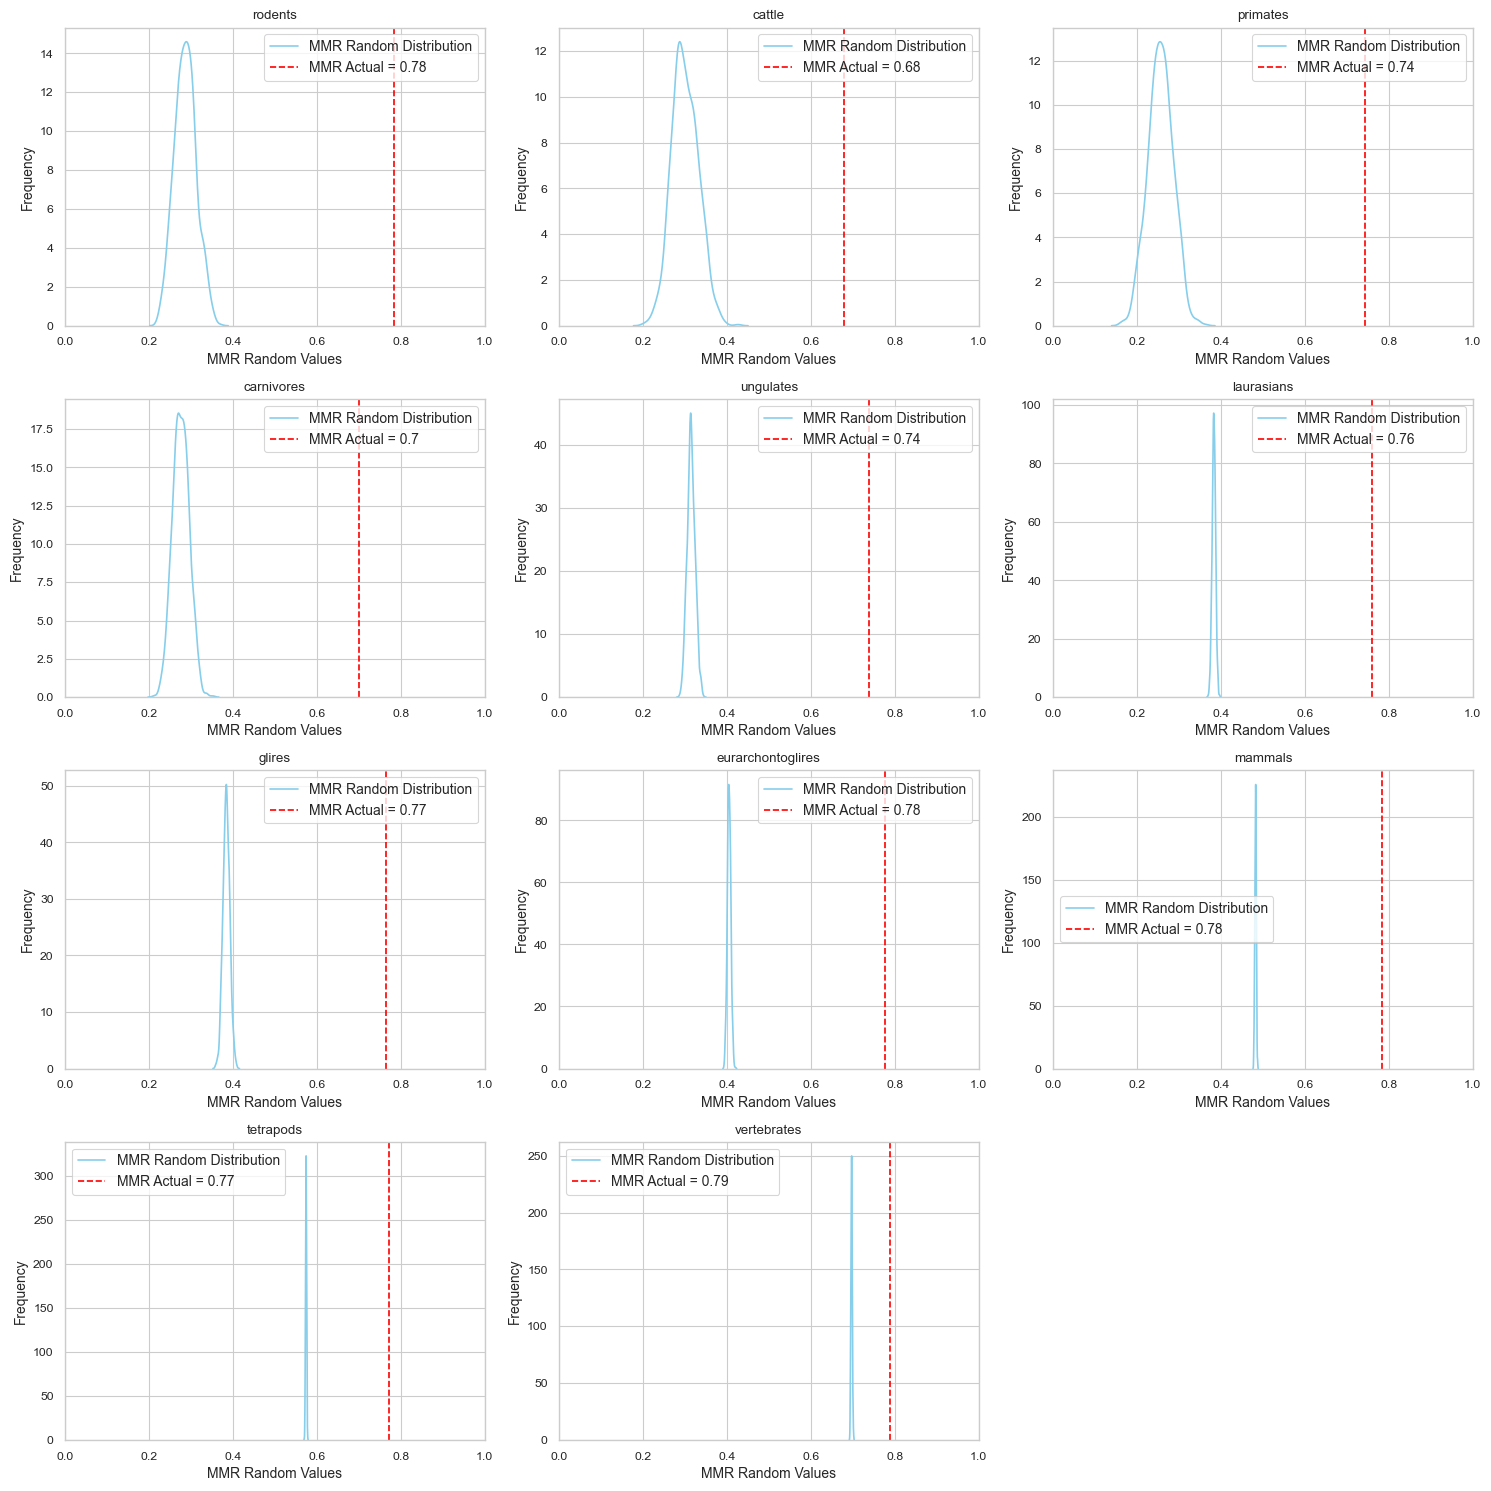

In [43]:
ncols = 3
nrows = (len(merged_df.alignment) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axes = axes.flatten()

for idx, (ax, (_, row)) in enumerate(zip(axes, merged_df.iterrows())):
        alignment = row["alignment"]
        mmr_distr = row["mmr_distr"]
        mmr_actual = row["mmr_actual"]
        # ax.hist(mmr_distr, bins=10, alpha=0.7, color="skyblue", label="MMR Random Distribution")
        sns.kdeplot(mmr_distr, color="skyblue", label="MMR Random Distribution",ax=ax)
        ax.axvline(x=mmr_actual, color="red", linestyle="--", label=f"MMR Actual = {round(mmr_actual,2)}")
        ax.set_title(alignment)
        ax.legend(fontsize=10)
        ax.set_xlabel("MMR Random Values",fontsize=10)
        ax.set_ylabel("Frequency",fontsize=10)
        ax.set_xlim(0,1)

# Hide empty subplots
for ax in axes[len(merged_df):]:
    ax.axis("off")

plt.tight_layout()
# plt.savefig("../images/supplementary/mmr_pval.svg",bbox_inches='tight')
# plt.savefig("../images/supplementary/mmr_pval.png",bbox_inches='tight',dpi=600)
plt.show()


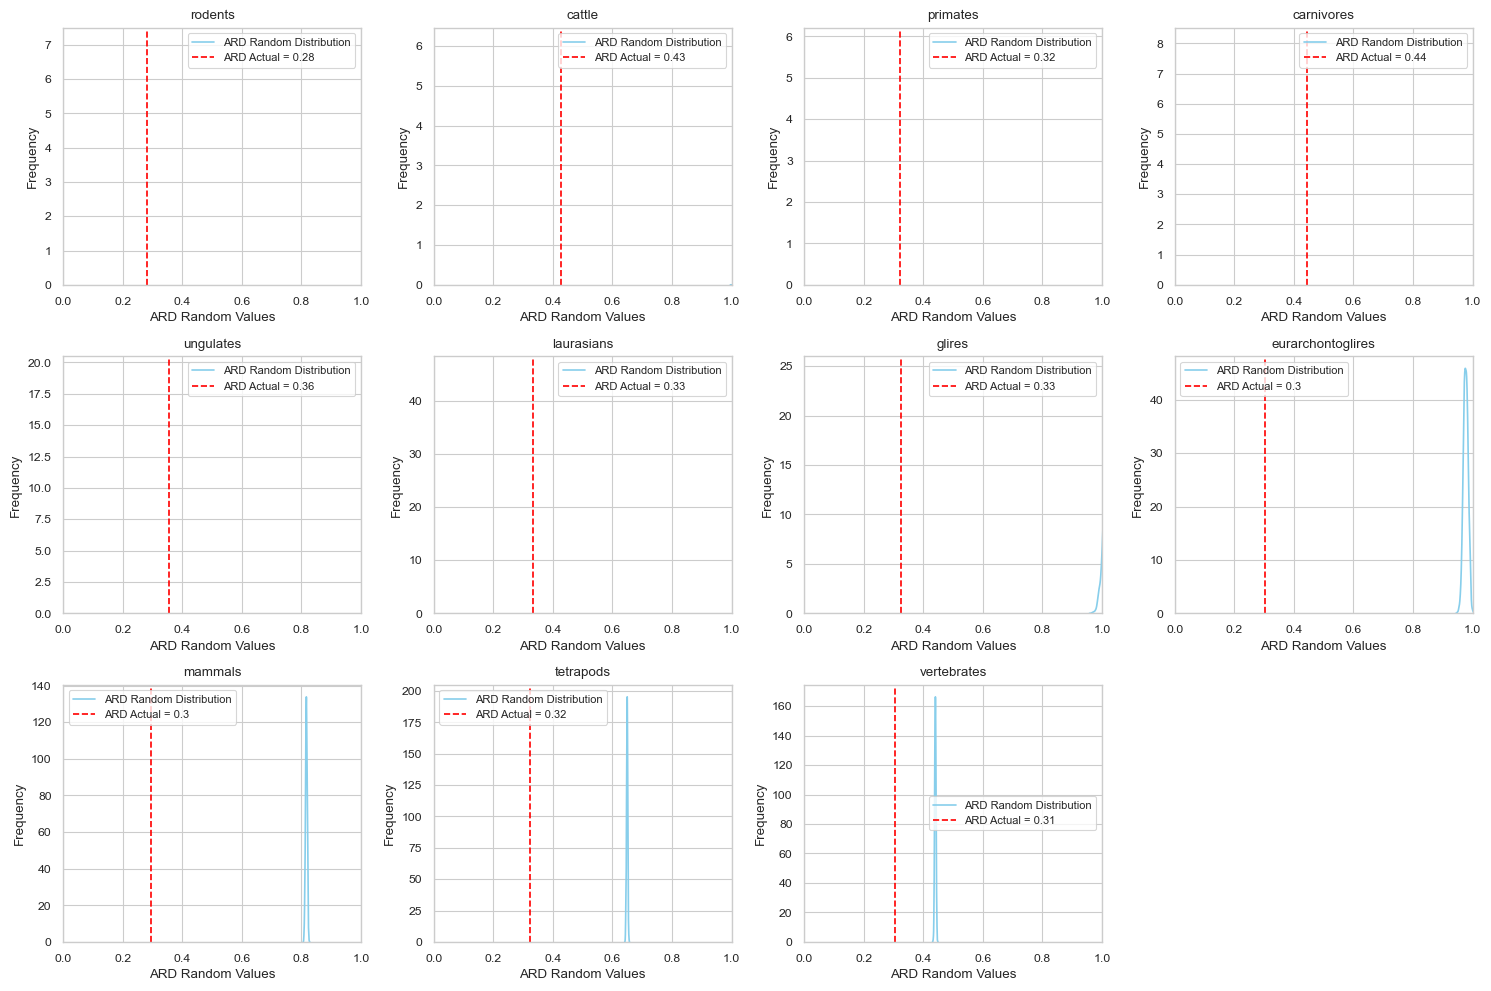

In [34]:
ncols = 3
nrows = (len(merged_df.alignment) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axes = axes.flatten()

for idx, (ax, (_, row)) in enumerate(zip(axes, merged_df.iterrows())):
        alignment = row["alignment"]
        mmr_distr = row["ard_distr"]
        mmr_actual = row["ard_actual"]
        sns.kdeplot(mmr_distr, color="skyblue", label="ARD Random Distribution",ax=ax)
        ax.axvline(x=mmr_actual, color="red", linestyle="--", label=f"ARD Actual = {round(mmr_actual,2)}")
        ax.set_title(alignment)
        ax.legend(fontsize=8)
        ax.set_xlabel("ARD Random Values")
        ax.set_ylabel("Frequency")
        ax.set_xlim(0,1)

# Hide empty subplots
for ax in axes[len(merged_df):]:
    ax.axis("off")

plt.tight_layout()
plt.show()